# Advanced Data Applications Report Script
### Author: 199103436

### Part 0: Pre-requisites

In [1]:
# Libraries

# Data manipulation
import pandas as pd
import numpy as np
#from similarity.jarowinkler import JaroWinkler
#from similarity.cosine import Cosine
import nltk, string
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import spacy
import jellyfish

nltk.download('punkt') # if necessary...
nltk.download('averaged_perceptron_tagger')

# Data visualisation
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

# Miscellanous 
import csv
import os
import datetime
import zipfile

# This makes out plots higher resolution, which makes them easier to see while building
plt.rcParams['figure.dpi'] = 100
import warnings
warnings.filterwarnings("ignore")

/Users/adumitru/opt/anaconda3/envs/ds2_mona/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/adumitru/opt/anaconda3/envs/ds2_mona/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/adumitru/opt/anaconda3/envs/ds2_mona/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/adumitru/opt

### Part 1: Data description

#### Part 1A: Data collection

In [2]:
# Check current directory
!pwd

/Users/adumitru/Library/CloudStorage/OneDrive-YorkStJohnUniversity/Year 3/Assignments/Advanced Data Applications


In [ ]:
# Collect zipped data via API call in the home directory of the project
!kaggle datasets download -d Cornell-University/arxiv

In [ ]:
# Unarchive the zip file into a JSON format
with zipfile.ZipFile("arxiv.zip","r") as zip_ref:
    zip_ref.extractall()

In [3]:
# Read the JSON file into a pandas data frame (takes a while to finish)
df = pd.read_json('arxiv-metadata-oai-snapshot.json', lines=True)

In [4]:
# Check the raw data
df.head()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
2,0704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]"
3,0704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,None,None,None,math.CO,None,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[[Callan, David, ]]"
4,0704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,None,"Illinois J. Math. 52 (2008) no.2, 681-689",None,None,math.CA math.FA,None,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]"


### Part 2: Data Analysis

### Task 3 objectives:
1. Remove records with no comments
2. Remove records with 'COVID' in the title
3. Retain only 5 columns: id, title, comments, journal-ref and categories
4. Report if there is any relation between journal-ref and categories
5. Construct ranking of all the words in the titles

In [5]:
# Task 3 - Objective 1: Remove records with no comments

# Check amount of missing records in the comments column
print(df[['comments']].isna().sum())

# Remove the records with missing comments
df.dropna(subset = ['comments'], inplace=True)

# Check if the comments column has any more missing rows
print(df[['comments']].isna().sum())

comments    461680
dtype: int64
comments    0
dtype: int64


In [6]:
# Task 3 - Objective 2: Remove records with 'COVID' in the title

# Check number of records before removal of COVID
print(len(df))

# Remove records with 'COVID' in title
df = df[~df.title.str.contains("COVID")]

# Check number of records after removal of COVID
print(len(df))

1603117
1601240


In [7]:
# Task 3 - Objective 3: Retain only 5 columns: id, title, comments, journal-ref and categories

# Delete redundant columns and store in new dataframe (or we can store inplace, without redundant columns, using inplace=True )
data = df.drop(['submitter','authors','doi','report-no','license','abstract','versions','update_date','authors_parsed'], axis=1)
data.head()

,id,title,comments,journal-ref,categories
0,0704.0001,Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",hep-ph
1,0704.0002,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,math.CO cs.CG
2,0704.0003,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,physics.gen-ph
3,0704.0004,A determinant of Stirling cycle numbers counts...,11 pages,None,math.CO
5,0704.0006,Bosonic characters of atomic Cooper pairs acro...,"6 pages, 4 figures, accepted by PRA",None,cond-mat.mes-hall


In [ ]:
# Alternatively, we can keep only the columns we want and save them 
# data = data[data['id','title','comments','journal-ref','categories']]

In [8]:
# Check missing data again
data.isna().sum()

id                  0
title               0
comments            0
journal-ref    950359
categories          0
dtype: int64

In [16]:
# Create separate dataset and clean it of missing journal-ref as these records won't be suitable for comparisons with categories
data_filtered = data.dropna(subset = ['journal-ref'])


In [17]:
# Task 3 - Objective 4: Report if there is any relation between journal-ref and categories

# Fill in jaro_distance column for similarity with 0s first
data_filtered['jaro_similarity'] = np.zeros(len(data_filtered))

# Calculate row-by-row similarity between journal-ref and categories
data_filtered['jaro_similarity'] = data_filtered.apply(lambda row : jellyfish.jaro_similarity(row['journal-ref'],
                                                                                              row['categories']), axis = 1)

In [18]:
data_filtered.head(5)

,id,title,comments,journal-ref,categories,jaro_similarity
0,0704.0001,Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",hep-ph,0.472222
6,0704.0007,Polymer Quantum Mechanics and its Continuum Limit,"16 pages, no figures. Typos corrected to match...","Phys.Rev.D76:044016,2007",gr-qc,0.000000
7,0704.0008,Numerical solution of shock and ramp compressi...,Minor corrections,"Journal of Applied Physics, vol 104, 073536 (2...",cond-mat.mtrl-sci,0.458693
14,0704.0015,Fermionic superstring loop amplitudes in the p...,22 pages; signs and coefficients adjusted for ...,"JHEP 0705:034,2007",hep-th,0.000000
15,0704.0016,Lifetime of doubly charmed baryons,"17 pages, 3 figures and 1 table","Commun.Theor.Phys.49:993-1000,2008",hep-ph,0.529412


In [93]:
# Summarise the jaro_similarity
print('The overall mean Jaro Similarity between Journal-ref & categories = ', round(data_filtered['jaro_similarity'].mean(),3))
print()
print('The overall median Jaro Similarity between Journal-ref & categories = ', round(data_filtered['jaro_similarity'].median(),3))
print()
print('The minimum Jaro Similarity between Journal-ref & categories = ', round(data_filtered['jaro_similarity'].min(),3))
print()
print('The maximum Jaro Similarity between Journal-ref & categories = ', round(data_filtered['jaro_similarity'].max(),3))

The overall mean Jaro Similarity between Journal-ref & categories =  0.388

The overall median Jaro Similarity between Journal-ref & categories =  0.399

The minimum Jaro Similarity between Journal-ref & categories =  0.0

The maximum Jaro Similarity between Journal-ref & categories =  0.722


Text(0.5, 1.0, 'Overall distribution of Jaro Similarity between journal-ref and categories')

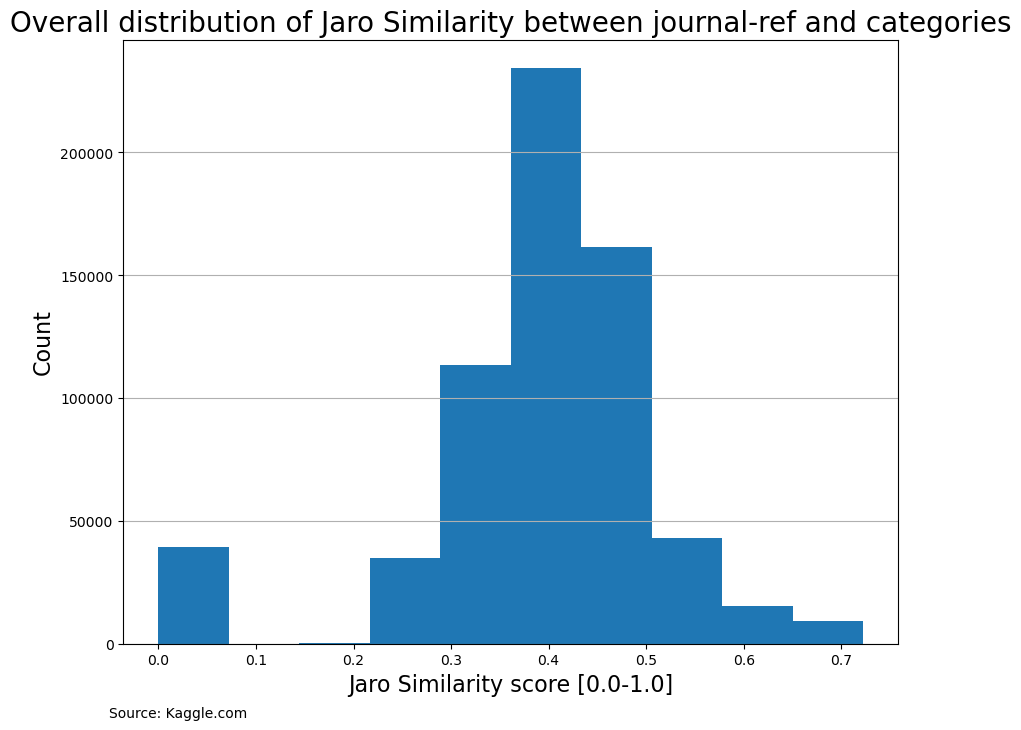

In [47]:
# Plot distribution of Jaro similarity between journal-ref and categories
figure(figsize=(10, 8), dpi=100)
data_filtered['jaro_similarity'].hist()
plt.xlabel("Jaro Similarity score [0.0-1.0]", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.annotate('Source: Kaggle.com', (0,0), (-10,-45), fontsize=10, 
             xycoords='axes fraction', textcoords='offset points', va='top')
plt.grid(False, axis='x')
plt.title("Overall distribution of Jaro Similarity between journal-ref and categories", fontsize=20)

In [48]:
# Task 3 - Objective 5: Construct ranking of all the words in the titles
# Naive approach for sense check
pd.Series(' '.join(data_filtered['title']).lower().split()).value_counts()[:100]

of              351408
the             275526
in              242780
and             211312
a               127453
                 ...  
solutions         5800
higgs             5775
nuclear           5711
search            5698
distribution      5671
Length: 100, dtype: int64

In [49]:
# Transform and clean title from potential Latex formating

from pylatexenc.latex2text import LatexNodes2Text

# LaTex to UTF
clean_title = []
for i,a in data_filtered.iterrows():
    # Clean title
    try:
        clean_title.append(LatexNodes2Text().latex_to_text(a['title']).replace('\n', ' ').strip()) 
    except:
        clean_title.append(a['abstract'].replace('\n', ' ').strip())

data_filtered['clean_title'] = clean_title

In [50]:
# Check clean_title
data_filtered.head(10)

,id,title,comments,journal-ref,categories,jaro_similarity,clean_title
0,0704.0001,Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",hep-ph,0.472222,Calculation of prompt diphoton production cros...
6,0704.0007,Polymer Quantum Mechanics and its Continuum Limit,"16 pages, no figures. Typos corrected to match...","Phys.Rev.D76:044016,2007",gr-qc,0.000000,Polymer Quantum Mechanics and its Continuum Limit
7,0704.0008,Numerical solution of shock and ramp compressi...,Minor corrections,"Journal of Applied Physics, vol 104, 073536 (2...",cond-mat.mtrl-sci,0.458693,Numerical solution of shock and ramp compressi...
14,0704.0015,Fermionic superstring loop amplitudes in the p...,22 pages; signs and coefficients adjusted for ...,"JHEP 0705:034,2007",hep-th,0.000000,Fermionic superstring loop amplitudes in the p...
15,0704.0016,Lifetime of doubly charmed baryons,"17 pages, 3 figures and 1 table","Commun.Theor.Phys.49:993-1000,2008",hep-ph,0.529412,Lifetime of doubly charmed baryons
16,0704.0017,Spectroscopic Observations of the Intermediate...,"10 pages, 11 figures (figures 3, 4, 7 and 8 at...","Mon.Not.Roy.Astron.Soc.378:211-220,2007",astro-ph,0.450855,Spectroscopic Observations of the Intermediate...
18,0704.0019,Approximation for extinction probability of th...,"6 pages, Journal-ref added","RIMS Kokyuroku, No.1551, pp.57-62 (2007)",math.PR math.AG,0.372222,Approximation for extinction probability of th...
19,0704.0020,Measurement of the Hadronic Form Factor in D0 ...,"21 pages, 13 postscript figures, submitted to ...","Phys.Rev.D76:052005,2007",hep-ex,0.472222,Measurement of the Hadronic Form Factor in D0 ...
20,0704.0021,Molecular Synchronization Waves in Arrays of A...,"5 pages, 4 figures","Phys. Rev. Lett. 99, 048301 (2007)",nlin.PS physics.chem-ph q-bio.MN,0.402206,Molecular Synchronization Waves in Arrays of A...
22,0704.0023,ALMA as the ideal probe of the solar chromosphere,"4 pages, 2 figures, to appear in the proceedin...","Astrophys.Space Sci.313:197-200,2008",astro-ph,0.546958,ALMA as the ideal probe of the solar chromosphere


In [51]:
# Check if there are roman numerals to be removed
data_filtered[data_filtered.clean_title.str.contains("III")].head()

,id,title,comments,journal-ref,categories,jaro_similarity,clean_title
119,0704.0120,Strong Phase and $D^0-D^0bar$ mixing at BES-III,"6 pages, 1 figure, a typo fixed, add more refe...","Phys.Rev.D75:094019,2007",hep-ex hep-ph,0.412393,Strong Phase and D^0-D^0bar mixing at BES-III
767,0704.0768,The luminous infrared composite Seyfert 2 gala...,"Accepted for publication in A&A, 9 pages, 6 fi...","Astronomy and Astrophysics, Volume 469, Issue ...",astro-ph,0.560464,The luminous infrared composite Seyfert 2 gala...
919,0704.0920,Two-proton radioactivity and three-body decay....,"19 pages, 20 figures","Phys.Rev.C76:014008,2007",nucl-th,0.394841,Two-proton radioactivity and three-body decay....
1539,0704.1540,The Orbifolds of Permutation-Type as Physical ...,23 pages,"Nucl.Phys.B786:297-312,2007",hep-th math-ph math.MP,0.304714,The Orbifolds of Permutation-Type as Physical ...
1824,0704.1825,Extended envelopes around Galactic Cepheids II...,accepted for publication in ApJ,"Astrophys.J.664:1093-1101,2007",astro-ph,0.650000,Extended envelopes around Galactic Cepheids II...


In [52]:
# Create function to remove roman numerals
def clean_roman_numerals(text):
    pattern = r"\b(?=[MDCLXVIΙ])M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})([IΙ]X|[IΙ]V|V?[IΙ]{0,3})\b\.?"
    return re.sub(pattern, '', text)

In [53]:
# Create a sample set to test the following tasks which are heavy
data_sample = data_filtered.sample(100000)
data_sample.head()

,id,title,comments,journal-ref,categories,jaro_similarity,clean_title
1960277,math/0204142,On lower semicontinuous multifunctions in quas...,11 pages,Proceedings of the Ninth Prague Topological Sy...,math.GN,0.452463,On lower semicontinuous multifunctions in quas...
923928,1712.05329,Broadband acoustic isolator in the audible ran...,"9 pages, 9 figures","Phys. Rev. Applied 12, 054033 (2019)",physics.app-ph cond-mat.mes-hall physics.class-ph,0.388293,Broadband acoustic isolator in the audible ran...
1826412,gr-qc/0506029,Massive Klein--Gordon equation from a BEC-base...,V1: 10 pages; uses revtex4; V2: two references...,Phys.Rev. D72 (2005) 044020,gr-qc,0.000000,Massive Klein–Gordon equation from a BEC-based...
485527,1312.4174,Nonequilibrium fluctuation-dissipation relatio...,This revised version is now accepted for publi...,"Journal of Chemical Physics 140, 144106 (2014)",cond-mat.stat-mech cond-mat.mes-hall quant-ph,0.421961,Nonequilibrium fluctuation-dissipation relatio...
55990,0803.4230,The Overdense Environment of a Large Lyman-alp...,"Accepted for publication in ApJL; 8 pages, 4 f...",Astrophys.J. 678 (2008) L77-80,astro-ph,0.650000,The Overdense Environment of a Large Lyman-alp...


In [55]:
# Create process to remove roman numerals AND punctuation marks AND lowercase everything

top_N = 10

data_sample['edited_title'] = data_filtered['clean_title']
for i in range(len(data_sample)):
    data_sample['edited_title'].iloc[i] = clean_roman_numerals(data_sample['clean_title'].iloc[i])

txt = data_sample.edited_title.str.lower().str.replace(r'[^a-zA-Z-]', ' ').str.cat(sep=' ')
txt = txt.replace('-', ' ')

words = nltk.tokenize.word_tokenize(txt)
word_dist = nltk.FreqDist(words)

stopwords = nltk.corpus.stopwords.words('english')
add_stopwords = [ 'show','results','also','two','using','study','present',
                  'one','paper','find','new','based',"''","'s",'used','non']
stopwords.extend(add_stopwords)
words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 


In [56]:
# Create extra process to remove roman numerals AND punctuation marks AND lowercase everything AND choose only nouns

# Function to test if something is a noun
is_noun = lambda pos: pos[:2] == 'NN'
# Tokenize and isolate nouns
tokenized = nltk.word_tokenize(txt)
words_only_nouns = nltk.FreqDist([word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)])

In [57]:
# Check top 10 words, including stopwords

print('All frequencies, including STOPWORDS:')
print('=' * 60)
result_with_stopwords = pd.DataFrame(word_dist.most_common(top_N),
                                     columns=['Word', 'Frequency']).set_index('Word')
print(result_with_stopwords)
print('=' * 60)


All frequencies, including STOPWORDS:
         Frequency
Word              
of           54032
the          42539
in           37555
and          32667
a            20131
for          15217
on           11808
with         10861
quantum       8543
to            7173


<AxesSubplot:xlabel='Word'>

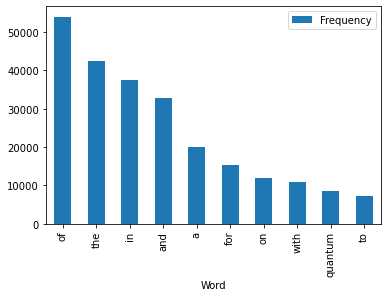

In [58]:
# Plot distribution of top 10 words
result_with_stopwords.plot.bar(rot=90)

In [59]:
# Check top 10 words, excluding stopwords

print('All frequencies, excluding STOPWORDS:')
print('=' * 60)

result_without_stopwords = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                                        columns=['Word', 'Frequency']).set_index('Word')
print(result_without_stopwords)
print('=' * 60)

All frequencies, excluding STOPWORDS:
             Frequency
Word                  
quantum           8543
model             5469
theory            4206
spin              3978
field             3584
energy            2969
dimensional       2852
systems           2675
phase             2620
magnetic          2587


<AxesSubplot:xlabel='Word'>

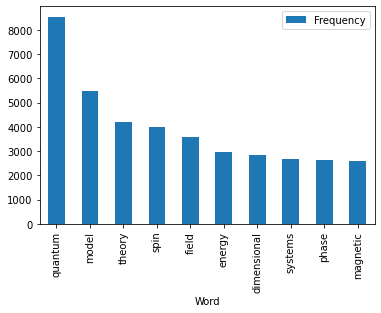

In [60]:
# Plot distribution of top 10 words
result_without_stopwords.plot.bar(rot=90)

In [61]:
df_result_without_stopwords = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                                           columns=['Word', 'Frequency'])

In [62]:
# Check top 10 words, excluding stopwords and focusing only on nouns / concepts

print('All frequencies, only NOUNS:')
print('=' * 60)
result_only_nouns = pd.DataFrame(words_only_nouns.most_common(top_N),
                                     columns=['Word', 'Frequency']).set_index('Word')
print(result_only_nouns)
print('=' * 60)


All frequencies, only NOUNS:
          Frequency
Word               
model          5284
quantum        5124
theory         3794
field          3584
energy         2969
spin           2901
systems        2675
models         2518
phase          2361
dynamics       2302


Text(0.5, 1.0, 'Top keywords across corpus of text with only nouns')

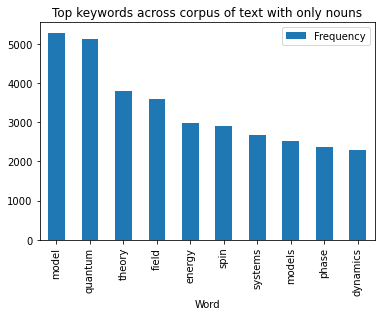

In [63]:
# Plot distribution of top 10 words, no stopwords, only nouns / concepts

result_only_nouns.plot.bar(rot=90)
plt.title('Top keywords across corpus of text with only nouns', fontsize=20)

In [64]:
df_result_only_nouns = pd.DataFrame(words_only_nouns.most_common(top_N),
                                     columns=['Word', 'Frequency'])

### Task 4 objectives:
1. Pick top 10 words
2. Recommend a journal for each word (top ranked journal)

In [65]:
# Task 4 - Objective 1: Pick top 10 words
df_result_only_nouns = pd.DataFrame(words_only_nouns.most_common(top_N),
                                    columns=['Word', 'Frequency'])
df_result_only_nouns

,Word,Frequency
0,model,5284
1,quantum,5124
2,theory,3794
3,field,3584
4,energy,2969
5,spin,2901
6,systems,2675
7,models,2518
8,phase,2361
9,dynamics,2302


In [66]:
# Task 4 - Objective 2: Recommend a journal for each word (top ranked journal)

# Create column for each of the 10 top words in main dataframe, then for each column-keyword, distribute per journal-ref the count 
# of times that keyword showed up across that journal-ref's titles

top_keywords = df_result_only_nouns['Word'].unique()
for keyword in top_keywords:
    print(keyword)
    data_sample[keyword] = data_sample.groupby(['journal-ref'])['edited_title'].transform(lambda x: x[x.str.contains(keyword)].count())
data_sample.reset_index()


model
quantum
theory
field
energy
spin
systems
models
phase
dynamics


,index,id,title,comments,journal-ref,categories,jaro_similarity,clean_title,temp_title,edited_title,model,quantum,theory,field,energy,spin,systems,models,phase,dynamics
0,1960277,math/0204142,On lower semicontinuous multifunctions in quas...,11 pages,Proceedings of the Ninth Prague Topological Sy...,math.GN,0.452463,On lower semicontinuous multifunctions in quas...,On lower semicontinuous multifunctions in quas...,On lower semicontinuous multifunctions in quas...,0,0,0,0,0,0,0,0,0,0
1,923928,1712.05329,Broadband acoustic isolator in the audible ran...,"9 pages, 9 figures","Phys. Rev. Applied 12, 054033 (2019)",physics.app-ph cond-mat.mes-hall physics.class-ph,0.388293,Broadband acoustic isolator in the audible ran...,Broadband acoustic isolator in the audible ran...,Broadband acoustic isolator in the audible ran...,0,0,0,0,0,0,0,0,0,0
2,1826412,gr-qc/0506029,Massive Klein--Gordon equation from a BEC-base...,V1: 10 pages; uses revtex4; V2: two references...,Phys.Rev. D72 (2005) 044020,gr-qc,0.000000,Massive Klein–Gordon equation from a BEC-based...,Massive Klein--Gordon equation from a BEC-base...,Massive Klein–Gordon equation from a BEC-based...,0,0,0,0,0,0,0,0,0,0
3,485527,1312.4174,Nonequilibrium fluctuation-dissipation relatio...,This revised version is now accepted for publi...,"Journal of Chemical Physics 140, 144106 (2014)",cond-mat.stat-mech cond-mat.mes-hall quant-ph,0.421961,Nonequilibrium fluctuation-dissipation relatio...,Nonequilibrium fluctuation-dissipation relatio...,Nonequilibrium fluctuation-dissipation relatio...,0,1,0,0,0,0,0,0,0,0
4,55990,0803.4230,The Overdense Environment of a Large Lyman-alp...,"Accepted for publication in ApJL; 8 pages, 4 f...",Astrophys.J. 678 (2008) L77-80,astro-ph,0.650000,The Overdense Environment of a Large Lyman-alp...,The Overdense Environment of a Large Lyman-alp...,The Overdense Environment of a Large Lyman-alp...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,690100,1512.07448,Bose-Einstein condensate in an optical lattice...,"10 pages, 5 figures","Phys. Rev. A 94, 043619 (2016)",cond-mat.quant-gas,0.225926,Bose-Einstein condensate in an optical lattice...,Bose-Einstein condensate in an optical lattice...,Bose-Einstein condensate in an optical lattice...,0,0,0,0,0,1,0,0,0,0
99996,603435,1503.00721,The Black Ring is Unstable,"10 pages, 6 figures","Phys. Rev. Lett. 114, 221101 (2015)",hep-th gr-qc,0.399206,The Black Ring is Unstable,The Black Ring is Unstable,The Black Ring is Unstable,0,0,0,0,0,0,0,0,0,0
99997,259457,1105.0192,Top quark mass measurement using the template ...,submitted to Phys. Rev. D,"Phys.Rev.D83:111101,2011",hep-ex,0.472222,Top quark mass measurement using the template ...,Top quark mass measurement using the template ...,Top quark mass measurement using the template ...,0,0,0,0,0,0,0,0,0,0
99998,1879314,hep-ph/0611113,$B_c(B){\to}D l\tilde{\nu}$ form factors in Li...,"12 pages, 3 figures","Chin.Phys.Lett.24:61-64,2007",hep-ph,0.424603,B_c(B)→D lν̃ form factors in Light-Cone Sum Ru...,$B_c(B){\to}D l\tilde{\nu}$ form factors in Li...,B_c(B)→ lν̃ form factors in Light-Cone Sum Rul...,0,0,0,0,0,0,0,0,0,0


In [72]:
# Print out 
for keyword in top_keywords:
    print("For the top-10 word [", keyword, "] the recommended journal is: [", data_sample.loc[data_sample[keyword].idxmax()]['journal-ref'], "]")
    print("Because the word [", keyword, "] appears ", data_sample.loc[data_sample[keyword].idxmax()][keyword], " times across the above journal's associated titles.")
    print()

For the top-10 word [ model ] the recommended journal is: [ Prog Theor Exp Phys (2018) ]
Because the word [ model ] appears  2  times across the above journal's associated titles.

For the top-10 word [ quantum ] the recommended journal is: [ In "Quantum Error Correction", edited by Daniel A. Lidar and Todd
  A. Brun, (Cambridge University Press, 2013) ]
Because the word [ quantum ] appears  2  times across the above journal's associated titles.

For the top-10 word [ theory ] the recommended journal is: [ Nucl.Phys. B585 (2000) 517-553 ]
Because the word [ theory ] appears  1  times across the above journal's associated titles.

For the top-10 word [ field ] the recommended journal is: [ PHYSICAL REVIEW B 76, 132501 (2007) ]
Because the word [ field ] appears  1  times across the above journal's associated titles.

For the top-10 word [ energy ] the recommended journal is: [ J. Mol. Spectrosc., 379, 111481 (2021) ]
Because the word [ energy ] appears  2  times across the above journal

In [88]:
# Extra: Find most similar title given the top keywords, regardless of the journal-ref
# Create the inital dataframe with the first topwords, top 1 title recommendation
initial_df = pd.DataFrame( 
        {'top_ranked_word': data_sample.apply(lambda row : df_result_only_nouns['Word'].iloc[0], axis = 1),
         'title': data_sample.apply(lambda row : row['edited_title'], axis = 1), 
         'jaro_distance': data_sample.apply(lambda row :  jellyfish.jaro_distance(row['edited_title'],
                                                                                  df_result_only_nouns['Word'].iloc[0]), axis = 1)}
).sort_values(by='jaro_distance', ascending=False).groupby('top_ranked_word').head(1)


In [89]:
# Adding one-by-one dataframes for the other topwords, with their respective top 1 title recommendation
for i in range(1,len(df_result_only_nouns)):
    addon_df = pd.DataFrame(
        {'top_ranked_word': data_sample.apply(lambda row : df_result_only_nouns['Word'].iloc[i], axis = 1),
         'title': data_sample.apply(lambda row : row['edited_title'], axis = 1), 
         'jaro_distance': data_sample.apply(lambda row :  jellyfish.jaro_distance(row['edited_title'],
                                                                                  df_result_only_nouns['Word'].iloc[i]), axis = 1)}
    ).sort_values(by='jaro_distance', ascending=False).groupby('top_ranked_word').head(1)
    initial_df = initial_df.append(addon_df)


In [90]:
# Show the best suited paper for a given top keyword
initial_df

,top_ranked_word,title,jaro_distance
43721,model,model on the circle,0.750000
498612,quantum,The quantum vacuum,0.796296
1937200,theory,S-Theory,0.819444
356366,field,q-Form fields on p-branes,0.733333
1690375,energy,The Blast Energy Efficiency of GRBs,0.723810
577351,spin,Weyl spin liquids,0.745098
42242,systems,Subsystem Code Constructions,0.750000
1650867,models,A model of mass extinction,0.743590
164078,phase,Group Chase and Escape,0.742424
492829,dynamics,Reeb dynamics detects odd balls,0.752688


In [ ]:
# Now run the analysis again but on the full dataset because we have ironed out the prototype above

In [73]:
# Create process to remove roman numerals AND punctuation marks AND lowercase everything

top_N = 10

data_filtered['edited_title'] = data_filtered['clean_title']
for i in range(len(data_filtered)):
    data_filtered['edited_title'].iloc[i] = clean_roman_numerals(data_filtered['clean_title'].iloc[i])

full_txt = data_filtered.edited_title.str.lower().str.replace(r'[^a-zA-Z-]', ' ').str.cat(sep=' ')
full_txt = full_txt.replace('-', ' ')

full_words = nltk.tokenize.word_tokenize(full_txt)
full_word_dist = nltk.FreqDist(full_words)

stopwords = nltk.corpus.stopwords.words('english')
# Add extra exception words for scientific papers specifically
add_stopwords = [ 'show','results','also','two','using','study','present',
                  'one','paper','find','new','based',"''","'s",'used','non']
stopwords.extend(add_stopwords)
full_words_except_stop_dist = nltk.FreqDist(w for w in full_words if w not in stopwords) 


In [74]:
# Create extra process to remove roman numerals AND punctuation marks AND lowercase everything AND choose only nouns

# Function to test if something is a noun
is_noun = lambda pos: pos[:2] == 'NN'
# Tokenize and isolate nouns
full_tokenized = nltk.word_tokenize(full_txt)
full_words_only_nouns = nltk.FreqDist([word for (word, pos) in nltk.pos_tag(full_tokenized) if is_noun(pos)])

In [75]:
# Check top 10 words, including stopwords

print('All frequencies, including STOPWORDS:')
print('=' * 60)
full_result_with_stopwords = pd.DataFrame(full_word_dist.most_common(top_N),
                                          columns=['Word', 'Frequency']).set_index('Word')
print(full_result_with_stopwords)
print('=' * 60)


All frequencies, including STOPWORDS:
         Frequency
Word              
of          352484
the         275863
in          244596
and         211803
a           131976
for          99049
on           76162
with         69735
quantum      55468
to           46642


<AxesSubplot:xlabel='Word'>

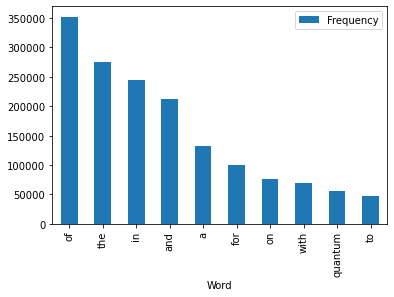

In [76]:
# Plot distribution of top 10 words
full_result_with_stopwords.plot.bar(rot=90)

In [77]:
# Check top 10 words, excluding stopwords

print('All frequencies, excluding STOPWORDS:')
print('=' * 60)

full_result_without_stopwords = pd.DataFrame(full_words_except_stop_dist.most_common(top_N),
                                             columns=['Word', 'Frequency']).set_index('Word')
print(full_result_without_stopwords)
print('=' * 60)

All frequencies, excluding STOPWORDS:
             Frequency
Word                  
quantum          55468
model            35537
theory           27192
spin             26015
field            23767
energy           18844
dimensional      18471
systems          17139
phase            17074
magnetic         16827


<AxesSubplot:xlabel='Word'>

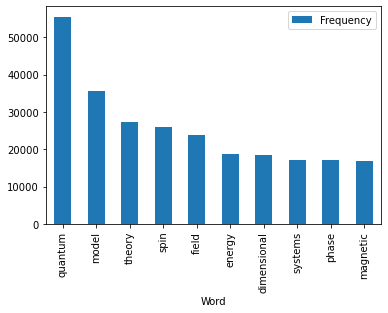

In [78]:
# Plot distribution of top 10 words
full_result_without_stopwords.plot.bar(rot=90)

In [108]:
full_df_result_without_stopwords = pd.DataFrame(full_words_except_stop_dist.most_common(top_N),
                                                columns=['Word', 'Frequency'])

In [80]:
# Check top 10 words, excluding stopwords and focusing only on nouns / concepts

print('All frequencies, only NOUNS:')
print('=' * 60)
full_result_only_nouns = pd.DataFrame(full_words_only_nouns.most_common(top_N),
                                      columns=['Word', 'Frequency']).set_index('Word')
print(full_result_only_nouns)
print('=' * 60)


All frequencies, only NOUNS:
          Frequency
Word               
model         34125
quantum       33444
theory        24690
field         23767
spin          19142
energy        18844
systems       17139
models        16114
phase         15374
dynamics      14656


Text(0.5, 1.0, 'Top keywords across corpus of text with only nouns')

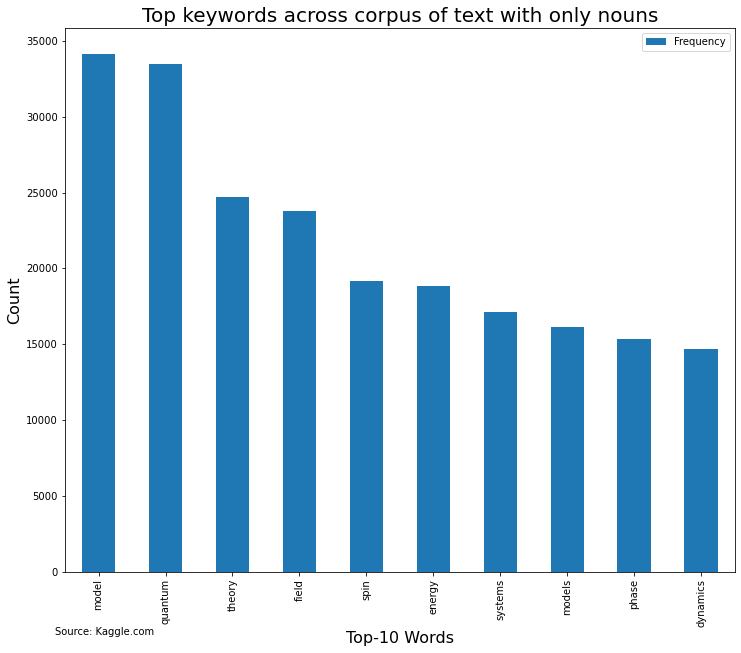

In [107]:
# Plot distribution of top 10 words, no stopwords, only nouns / concepts
full_result_only_nouns.plot(figsize=(12, 10),kind='bar')
plt.xlabel("Top-10 Words", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.annotate('Source: Kaggle.com', (0,0), (-10,-55), fontsize=10, 
             xycoords='axes fraction', textcoords='offset points', va='top')
# plt.grid(False, axis='x')
plt.title("Top keywords across corpus of text with only nouns", fontsize=20)

In [82]:
full_df_result_only_nouns = pd.DataFrame(full_words_only_nouns.most_common(top_N),
                                         columns=['Word', 'Frequency'])

### Task 4 objectives:
1. Pick top 10 words
2. Recommend a journal for each word (top ranked journal)

In [83]:
# Task 4 - Objective 1: Pick top 10 words
full_df_result_only_nouns = pd.DataFrame(full_words_only_nouns.most_common(top_N),
                                         columns=['Word', 'Frequency'])
full_df_result_only_nouns

,Word,Frequency
0,model,34125
1,quantum,33444
2,theory,24690
3,field,23767
4,spin,19142
5,energy,18844
6,systems,17139
7,models,16114
8,phase,15374
9,dynamics,14656


In [84]:
# Task 4 - Objective 2: Recommend a journal for each word (top ranked journal)

# Create column for eadata_filterede 10 top words in main dataframe, then for each column-keyword, distribute per journal-ref the count 
# of times that keyword showed up across that journal-ref's titles

full_top_keywords = full_df_result_only_nouns['Word'].unique()
for keyword in full_top_keywords:
    # Print keyword to check progress
    print(keyword)
    data_filtered[keyword] = data_filtered.groupby(['journal-ref'])['edited_title'].transform(lambda x: x[x.str.contains(keyword)].count())
data_filtered.reset_index()


model
quantum
theory
field
spin
energy
systems
models
phase
dynamics


,index,id,title,comments,journal-ref,categories,jaro_similarity,clean_title,edited_title,model,quantum,theory,field,spin,energy,systems,models,phase,dynamics
0,0,0704.0001,Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",hep-ph,0.472222,Calculation of prompt diphoton production cros...,Calculation of prompt diphoton production cros...,0,0,0,0,0,0,0,0,0,0
1,6,0704.0007,Polymer Quantum Mechanics and its Continuum Limit,"16 pages, no figures. Typos corrected to match...","Phys.Rev.D76:044016,2007",gr-qc,0.000000,Polymer Quantum Mechanics and its Continuum Limit,Polymer Quantum Mechanics and its Continuum Limit,0,0,0,0,0,0,0,0,0,0
2,7,0704.0008,Numerical solution of shock and ramp compressi...,Minor corrections,"Journal of Applied Physics, vol 104, 073536 (2...",cond-mat.mtrl-sci,0.458693,Numerical solution of shock and ramp compressi...,Numerical solution of shock and ramp compressi...,0,0,0,0,0,0,0,0,0,0
3,14,0704.0015,Fermionic superstring loop amplitudes in the p...,22 pages; signs and coefficients adjusted for ...,"JHEP 0705:034,2007",hep-th,0.000000,Fermionic superstring loop amplitudes in the p...,Fermionic superstring loop amplitudes in the p...,0,0,0,0,1,0,0,0,0,0
4,15,0704.0016,Lifetime of doubly charmed baryons,"17 pages, 3 figures and 1 table","Commun.Theor.Phys.49:993-1000,2008",hep-ph,0.529412,Lifetime of doubly charmed baryons,Lifetime of doubly charmed baryons,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650876,2064785,supr-con/9608001,Topology and Phase Transitions in the Little-P...,"Latex, 26 pages, 5 figs upon request",SIAM J Appl Math {\bf 58} (1998) 103--121,supr-con cond-mat.supr-con quant-ph,0.344070,Topology and Phase Transitions in the Little-P...,Topology and Phase Transitions in the Little-P...,0,0,0,0,0,0,0,0,0,0
650877,2064787,supr-con/9608003,Extended bound states and resonances of two fe...,"21 pages, RevTeX, 4 Postscript figures, arithm...","Phys. Rev. B 55, 6035 (1997)",supr-con cond-mat.supr-con,0.296398,Extended bound states and resonances of two fe...,Extended bound states and resonances of two fe...,0,0,0,0,0,0,0,0,0,0
650878,2064788,supr-con/9608004,Ginzburg-Landau-Gor'kov Theory of Magnetic osc...,"39 pages, 8 figures. This is a replacement of ...",PHYS REV B 56: (2) 809-825 JUL 1 1997,supr-con cond-mat.supr-con,0.376992,Ginzburg-Landau-Gor'kov Theory of Magnetic osc...,Ginzburg-Landau-Gor'kov Theory of Magnetic osc...,0,0,0,0,0,0,0,0,0,0
650879,2064789,supr-con/9608005,Evidence for Quasiparticle Decay in Photoemiss...,"4 pages of ReVTeX, 3 eps figures","Phys. Rev. Lett. 79, 1726 (1997)",supr-con cond-mat.supr-con,0.342949,Evidence for Quasiparticle Decay in Photoemiss...,Evidence for Quasiparticle Decay in Photoemiss...,0,0,0,0,0,0,0,0,0,0


In [109]:
# Print out 
for keyword in full_top_keywords:
    print("For the top-10 word [", keyword, "] the recommended journal is: [", data_filtered.loc[data_filtered[keyword].idxmax()]['journal-ref'], "]")
    print("Because the word [", keyword, "] appears ", data_filtered.loc[data_filtered[keyword].idxmax()][keyword], 
          " times across the above journal's associated titles.")
    print()

For the top-10 word [ model ] the recommended journal is: [ Prog Theor Exp Phys (2020) ]
Because the word [ model ] appears  11  times across the above journal's associated titles.

For the top-10 word [ quantum ] the recommended journal is: [ In "Quantum Error Correction", edited by Daniel A. Lidar and Todd
  A. Brun, (Cambridge University Press, 2013) ]
Because the word [ quantum ] appears  3  times across the above journal's associated titles.

For the top-10 word [ theory ] the recommended journal is: [ Prog Theor Exp Phys (2018) ]
Because the word [ theory ] appears  7  times across the above journal's associated titles.

For the top-10 word [ field ] the recommended journal is: [ Prog Theor Exp Phys (2018) ]
Because the word [ field ] appears  6  times across the above journal's associated titles.

For the top-10 word [ spin ] the recommended journal is: [ Prog Theor Exp Phys (2019) ]
Because the word [ spin ] appears  3  times across the above journal's associated titles.

For t

In [86]:
len(data_filtered)

650881

In [ ]:
# Extra: Find most similar title given the top keywords, regardless of the journal-ref
# Create the inital dataframe with the first topwords, top 1 title recommendation
initial_df = pd.DataFrame( 
        {'top_ranked_word': data_sample.apply(lambda row : df_result_only_nouns['Word'].iloc[0], axis = 1),
         'title': data_sample.apply(lambda row : row['clean_title'], axis = 1), 
         'jaro_distance': data_sample.apply(lambda row :  jellyfish.jaro_distance(row['clean_title'],
                                                                                  df_result_only_nouns['Word'].iloc[0]), axis = 1)}
).sort_values(by='jaro_distance', ascending=False).groupby('top_ranked_word').head(1)


In [ ]:
# Adding one-by-one dataframes for the other topwords, with their respective top 1 title recommendation
for i in range(1,len(df_result_only_nouns)):
    addon_df = pd.DataFrame(
        {'top_ranked_word': data_sample.apply(lambda row : df_result_only_nouns['Word'].iloc[i], axis = 1),
         'title': data_sample.apply(lambda row : row['clean_title'], axis = 1), 
         'jaro_distance': data_sample.apply(lambda row :  jellyfish.jaro_distance(row['clean_title'],
                                                                                  df_result_only_nouns['Word'].iloc[i]), axis = 1)}
    ).sort_values(by='jaro_distance', ascending=False).groupby('top_ranked_word').head(1)
    initial_df = initial_df.append(addon_df)


In [ ]:
# Bullshit Trial and error below, ignore

In [ ]:
temp_dict = {}
for i in range(len(df_result_only_nouns)):
    temp_dict['top_ranked_word'] = data_sample.apply(lambda row : df_result_only_nouns['Word'].iloc[i], axis = 1),
    temp_dict['title'] = data_sample.apply(lambda row : row['title'], axis = 1), 
    temp_dict['jaro_distance'] = data_sample.apply(lambda row :  jellyfish.jaro_distance(row['title'],
                                                                                         df_result_only_nouns['Word'].iloc[i]), axis = 1)

In [ ]:
pd.DataFrame(
        {'top_ranked_word': data_sample.apply(lambda row : df_result_only_nouns['Word'].iloc[i], axis = 1),
         'title': data_sample.apply(lambda row : row['clean_title'], axis = 1), 
         'jaro_distance': data_sample.apply(lambda row :  jellyfish.jaro_distance(row['clean_title'],
                                                                                  df_result_only_nouns['Word'].iloc[i]), axis = 1)}
    ).sort_values(by='jaro_distance', ascending=False).groupby('top_ranked_word').head(10)

In [ ]:
data_sample.apply(lambda row : (row, jellyfish.jaro_distance(row['title'],
                                                                       df_result_only_nouns['Word'].iloc[0])), axis = 1)

In [ ]:
# Setup plot size.
fig, ax = plt.subplots(figsize=(3,6))

# Create grid 
# Zorder tells it which layer to put it on. We are setting this to 1 and our data to 2 so the grid is behind the data.
ax.grid(which="major", axis='x', color='#758D99', alpha=0.6, zorder=1)

# Remove splines. Can be done one at a time or can slice with a list.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Make left spine slightly thicker
ax.spines['left'].set_linewidth(1.1)
ax.spines['left'].set_linewidth(1.1)

# Setup data
token_nouns = df_result_only_nouns.sort_values(by='Frequency', ascending=True)

# Plot data
ax.barh(token_nouns['Word'], token_nouns['Frequency'], color='#006BA2', zorder=2)

# Set custom labels for x-axis
ax.set_xticks([0, 100, 200, 300, 400, 500])
ax.set_xticklabels([0, 100, 200, 300, 400, 500])

# Reformat x-axis tick labels
ax.xaxis.set_tick_params(labeltop=True,      # Put x-axis labels on top
                         labelbottom=False,  # Set no x-axis labels on bottom
                         bottom=False,       # Set no ticks on bottom
                         labelsize=11,       # Set tick label size
                         pad=-1)             # Lower tick labels a bit

# Reformat y-axis tick labels
ax.set_yticklabels(token_nouns['Word'],      # Set labels again
                   ha = 'left')              # Set horizontal alignment to left
ax.yaxis.set_tick_params(pad=100,            # Pad tick labels so they don't go over y-axis
                         labelsize=11,       # Set label size
                         bottom=False)       # Set no ticks on bottom/left

# Shrink y-lim to make plot a bit tighter
ax.set_ylim(-0.5, 9.5)

# Add in line and tag
ax.plot([-.35, 0.95],                 # Set width of line
        [1.02, 1.02],                # Set height of line
        transform=fig.transFigure,   # Set location relative to plot
        clip_on=False, 
        color='#E3120B', 
        linewidth=.6)
ax.add_patch(plt.Rectangle((-.35,1.02),                # Set location of rectangle by lower left corder
                           0.12,                       # Width of rectangle
                           -0.02,                      # Height of rectangle. Negative so it goes down.
                           facecolor='#E3120B', 
                           transform=fig.transFigure, 
                           clip_on=False, 
                           linewidth = 0))

# Add in title and subtitle
ax.text(x=-.35, y=.96, s="Words that are only nouns or concepts", transform=fig.transFigure, ha='left', fontsize=13, weight='bold', alpha=.8)
ax.text(x=-.35, y=.925, s="Kaggle dataset", transform=fig.transFigure, ha='left', fontsize=11, alpha=.8)

# Set source text
ax.text(x=-.35, y=.08, s="""Source: "Kaggle.com, arXiv dataset" """ , transform=fig.transFigure, ha='left', fontsize=9, alpha=.7)

# Export plot as high resolution PNG
plt.savefig('token_nouns.png',             # Set path and filename
            dpi = 300,                     # Set dots per inch
            bbox_inches="tight",           # Remove extra whitespace around plot
            facecolor='white')             # Set background color to white

In [ ]:
# Setup plot size.
fig, ax = plt.subplots(figsize=(3,6))

# Create grid 
# Zorder tells it which layer to put it on. We are setting this to 1 and our data to 2 so the grid is behind the data.
ax.grid(which="major", axis='x', color='#758D99', alpha=0.6, zorder=1)

# Remove splines. Can be done one at a time or can slice with a list.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Make left spine slightly thicker
ax.spines['left'].set_linewidth(1.1)
ax.spines['left'].set_linewidth(1.1)

# Setup data
token_words_without_stopwords = df_result_without_stopwords.sort_values(by='Frequency', ascending=True)

# Plot data
ax.barh(token_words_without_stopwords['Word'], token_words_without_stopwords['Frequency'], color='#006BA2', zorder=2)

# Set custom labels for x-axis
ax.set_xticks([0, 250, 500, 750, 1000, 1250])
ax.set_xticklabels([0, 250, 500, 750, 1000, 1250])

# Reformat x-axis tick labels
ax.xaxis.set_tick_params(labeltop=True,      # Put x-axis labels on top
                         labelbottom=False,  # Set no x-axis labels on bottom
                         bottom=False,       # Set no ticks on bottom
                         labelsize=11,       # Set tick label size
                         pad=-1)             # Lower tick labels a bit

# Reformat y-axis tick labels
ax.set_yticklabels(token_words_without_stopwords['Word'],      # Set labels again
                   ha = 'left')              # Set horizontal alignment to left
ax.yaxis.set_tick_params(pad=100,            # Pad tick labels so they don't go over y-axis
                         labelsize=11,       # Set label size
                         bottom=False)       # Set no ticks on bottom/left

# Shrink y-lim to make plot a bit tighter
ax.set_ylim(-0.5, 9.5)

# Add in line and tag
ax.plot([-.35, 0.95],                 # Set width of line
        [1.02, 1.02],                # Set height of line
        transform=fig.transFigure,   # Set location relative to plot
        clip_on=False, 
        color='#E3120B', 
        linewidth=.6)
ax.add_patch(plt.Rectangle((-.35,1.02),                # Set location of rectangle by lower left corder
                           0.12,                       # Width of rectangle
                           -0.02,                      # Height of rectangle. Negative so it goes down.
                           facecolor='#E3120B', 
                           transform=fig.transFigure, 
                           clip_on=False, 
                           linewidth = 0))

# Add in title and subtitle
ax.text(x=-.35, y=.96, s="Most common words without stopwords", transform=fig.transFigure, ha='left', fontsize=13, weight='bold', alpha=.8)
ax.text(x=-.35, y=.925, s="arXiv Kaggle dataset", transform=fig.transFigure, ha='left', fontsize=11, alpha=.8)

# Set source text
ax.text(x=-.35, y=.08, s="""Source: "Kaggle.com, arXiv dataset" """ , transform=fig.transFigure, ha='left', fontsize=9, alpha=.7)

# Export plot as high resolution PNG
plt.savefig('token_words_without_stopwords.png',             # Set path and filename
            dpi = 300,                     # Set dots per inch
            bbox_inches="tight",           # Remove extra whitespace around plot
            facecolor='white')             # Set background color to white

In [ ]:
data_filtered.head(10)

In [ ]:
# Objective 4: 
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

# def stem_tokens(tokens):
#     return [stemmer.stem(item) for item in tokens]

# '''remove punctuation, lowercase, stem'''
# def normalize(text):
#     return stem_tokens(nltk.word_tokenize(text.lower().translate(remove_punctuation_map)))

tfidf_vectorizer=TfidfVectorizer(analyzer="char")

tfidf_vectorizer=TfidfVectorizer(token_pattern=u'(?u)\\b\w+\\b')

def cosine_sim(text1, text2):
    tfidf = tfidf_vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]


print(cosine_sim('a.little.bird', 'a little bird'))
print(cosine_sim('a little brd', 'a little bird chirps'))
print(cosine_sim('a little bird', 'a big dog barks'))

In [ ]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
tokenizer.tokenize('a.little.bird')

In [ ]:
print(cosine_sim('Astroph','astro-ph'))

In [ ]:
data_filtered['cosine_similarity'] = np.zeros(len(data_filtered))

In [ ]:

for i in range(len(data_filtered)):
    data_filtered['cosine_similarity'].iloc[i] = cosine_sim(data_filtered['journal-ref'].iloc[i],data_filtered['categories'].iloc[i])
    

In [ ]:
data_filtered.head(10)

In [ ]:
print(cosine_sim('Astrophys.Space Sci.313:197-200,2008','astro-ph'))

In [ ]:
import spacy_sentence_bert
import pandas as pd
nlp = spacy_sentence_bert.load_model('en_roberta_large_nli_stsb_mean_tokens')

similarityValue = []

for i in range(data_filtered.count()[0]):
    sentence_1 = nlp(data_filtered.iloc[i]['journal-ref'])
    sentence_2 = nlp(data_filtered.iloc[i]['categories'])
    similarityValue.append(sentence_1.similarity(sentence_2))
    print(sentence_1, '|', sentence_2, '|', sentence_1.similarity(sentence_2))

data_filtered['Similarity'] = similarityValue

In [ ]:
import pandas as pd 
import spacy

nlp = spacy.load("en_core_web_sm") 

def get_similarity(term1, term2):
    tokens = nlp(term1 + " " + term2)

    print(tokens[0].text, "|",tokens[1].text, tokens[0].similarity(tokens[1]))

    return tokens[0].similarity(tokens[1])

In [ ]:
data_filtered['A_B_similarity'] = data_filtered.apply(lambda x: get_similarity(x['journal-ref'], x['categories']), axis = 1)
